In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, Callback
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras import backend as K

2024-07-06 08:19:13.906954: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-06 08:19:14.250947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-06 08:19:15.148337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Configurer TensorFlow pour utiliser le GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-07-06 08:19:18.219187: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-06 08:19:18.379311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-06 08:19:18.381653: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Activer la précision mixte
from tensorflow.keras.mixed_precision import Policy
policy = Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [4]:
# Nettoyage de la mémoire (au cas où :D)
K.clear_session()

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 50
CWD = Path.cwd()
NEW_TRAIN = CWD / "sorted_data" / "train"
NEW_VAL = CWD / "sorted_data" / "val"
NEW_TEST = CWD / "sorted_data" / "test"
class_names = {0: 'NORMAL', 1: 'VIRUS', 2: 'BACTERIA'}

In [6]:
# Utiliser image_dataset_from_directory pour charger les datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_TRAIN,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_VAL,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_TEST,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Appliquer le prétraitement spécifique à VGG16
def preprocess(image, label):
    return preprocess_input(image), label

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 12484 files belonging to 3 classes.
Found 288 files belonging to 3 classes.
Found 822 files belonging to 3 classes.


In [7]:
# Augmentation des données
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten(name='new_flatten')(x)
x = Dense(320, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(320, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
classifieur = Dense(3, activation='softmax', dtype='float32')(x)  # 3 classes: NORMAL, BACTERIA, VIRUS

new_model = Model(inputs=base_model.input, outputs=classifieur)

In [9]:
# Geler les couches de base
for layer in base_model.layers:
    layer.trainable = False

new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │     8,028,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,849,411 (87.16 MB)

 Trainable params: 8,133,443 (31.03 MB)

 Non-trainable params: 14,715,968 (56.14 MB)

In [10]:
# Callbacks pour l'entraînement
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)

es = EarlyStopping(
    monitor="val_loss", 
    mode="min", 
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [11]:
# Callback pour évaluation intermédiaire
class IntermediateEvaluation(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:  # Evaluate every 5 epochs
            test_loss, test_accuracy, test_recall = self.model.evaluate(test_dataset)
            print(f"Epoch {epoch} - Test loss: {test_loss}, Test accuracy: {test_accuracy}, Test recall: {test_recall}")

In [12]:
callbacks = [es, reduce_lr, lr_scheduler, IntermediateEvaluation()]

history = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS, 
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/50


I0000 00:00:1720246768.970857    4987 service.cc:145] XLA service 0x7613f80067e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720246768.971045    4987 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-07-06 08:19:29.064960: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-06 08:19:29.340277: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   3/1561 ━━━━━━━━━━━━━━━━━━━━ 1:31 59ms/step - accuracy: 0.3125 - loss: 11.2633 - recall: 0.2639 

I0000 00:00:1720246775.088437    4987 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.6543 - loss: 7.4535 - recall: 0.6252
Epoch 0 - Test loss: 7.342456340789795, Test accuracy: 0.669099748134613, Test recall: 0.6484184861183167
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 115s 64ms/step - accuracy: 0.5106 - loss: 9.4006 - recall: 0.4890 - val_accuracy: 0.6701 - val_loss: 7.4098 - val_recall: 0.6528 - learning_rate: 1.0000e-04
Epoch 2/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 85s 54ms/step - accuracy: 0.6185 - loss: 6.9740 - recall: 0.6011 - val_accuracy: 0.4757 - val_loss: 6.5841 - val_recall: 0.4688 - learning_rate: 1.0000e-04
Epoch 3/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 84s 54ms/step - accuracy: 0.6428 - loss: 5.2535 - recall: 0.6224 - val_accuracy: 0.6910 - val_loss: 4.3716 - val_recall: 0.6771 - learning_rate: 1.0000e-04
Epoch 4/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 84s 54ms/step - accuracy: 0.6524 - loss: 3.9737 - recall: 0.6267 - val_accuracy: 0.6493 - val_loss: 3.2685 - val_recall: 0.6146 - learning_rate: 1.0000e-04
Epoch 5/50
1561/156

In [13]:
# Dégelez les dernières couches du modèle de base pour le fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │     8,028,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,849,411 (87.16 MB)

 Trainable params: 15,212,867 (58.03 MB)

 Non-trainable params: 7,636,544 (29.13 MB)

In [14]:
history_finetune = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=20,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8673 - loss: 0.5942 - recall_1: 0.8554
Epoch 0 - Test loss: 0.7987223267555237, Test accuracy: 0.7396593689918518, Test recall: 0.7238442897796631
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 103s 64ms/step - accuracy: 0.6577 - loss: 0.9231 - recall_1: 0.5992 - val_accuracy: 0.6597 - val_loss: 0.8994 - val_recall_1: 0.6042 - learning_rate: 1.0000e-04
Epoch 2/20
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 93s 59ms/step - accuracy: 0.7383 - loss: 0.7249 - recall_1: 0.6985 - val_accuracy: 0.3924 - val_loss: 1.7236 - val_recall_1: 0.3819 - learning_rate: 1.0000e-04
Epoch 3/20
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 93s 59ms/step - accuracy: 0.7099 - loss: 0.7492 - recall_1: 0.6565 - val_accuracy: 0.5035 - val_loss: 1.0777 - val_recall_1: 0.4549 - learning_rate: 1.0000e-04
Epoch 4/20
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 94s 60ms/step - accuracy: 0.6966 - loss: 0.7450 - recall_1: 0.6351 - val_accuracy: 0.6771 - val_loss: 0.7637 - val_recall_1: 0.6181 - learning_rate:

In [15]:
# Dégelez les 8 dernières couches du modèle de base pour le fine-tuning
for layer in base_model.layers[-8:]:
    layer.trainable = True

new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │     8,028,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,849,411 (87.16 MB)

 Trainable params: 21,112,643 (80.54 MB)

 Non-trainable params: 1,736,768 (6.63 MB)

In [16]:
history_finetune_2 = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=30, 
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/30


2024-07-06 09:23:45.066150: W external/local_tsl/tsl/framework/bfc_allocator.cc:368] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2024-07-06 09:23:45.726099: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 748/1561 ━━━━━━━━━━━━━━━━━━━━ 1:06 82ms/step - accuracy: 0.6146 - loss: 0.8858 - recall_2: 0.5439

2024-07-06 09:24:49.627577: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2535 - loss: 1.4675 - recall_2: 0.2309
Epoch 0 - Test loss: 1.172760248184204, Test accuracy: 0.4866180121898651, Test recall: 0.46836984157562256
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 142s 87ms/step - accuracy: 0.6230 - loss: 0.8606 - recall_2: 0.5450 - val_accuracy: 0.5382 - val_loss: 1.4632 - val_recall_2: 0.5347 - learning_rate: 1.0000e-04
Epoch 2/30
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 129s 83ms/step - accuracy: 0.6975 - loss: 0.7281 - recall_2: 0.6360 - val_accuracy: 0.5035 - val_loss: 1.2501 - val_recall_2: 0.4688 - learning_rate: 1.0000e-04
Epoch 3/30
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 130s 83ms/step - accuracy: 0.7061 - loss: 0.7064 - recall_2: 0.6591 - val_accuracy: 0.6181 - val_loss: 1.0350 - val_recall_2: 0.5799 - learning_rate: 1.0000e-04
Epoch 4/30
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 130s 83ms/step - accuracy: 0.7220 - loss: 0.6833 - recall_2: 0.6811 - val_accuracy: 0.5243 - val_loss: 1.1890 - val_recall_2: 0.4931 - learning_rate: 1.0000e

In [17]:
# Fine-tuning final avec toutes les couches dégélées
for layer in base_model.layers:
    layer.trainable = True

new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │     8,028,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,849,411 (87.16 MB)

 Trainable params: 22,848,131 (87.16 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [18]:
history_finetune_3 = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS, 
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/50


2024-07-06 10:30:00.169484: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-06 10:30:01.649430: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-06 10:30:02.703191: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   1/1561 ━━━━━━━━━━━━━━━━━━━━ 6:37:26 15s/step - accuracy: 1.0000 - loss: 0.2318 - recall_3: 1.0000

I0000 00:00:1720254604.708017    4989 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 164 bytes spill stores, 164 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 36 bytes spill stores, 36 bytes spill loads



 925/1561 ━━━━━━━━━━━━━━━━━━━━ 1:29 141ms/step - accuracy: 0.5948 - loss: 0.9344 - recall_3: 0.5365

2024-07-06 10:32:19.701981: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-06 10:32:20.556696: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.07GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-06 10:32:21.209982: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 926/1561 ━━━━━━━━━━━━━━━━━━━━ 1:35 150ms/step - accuracy: 0.5949 - loss: 0.9343 - recall_3: 0.5365

I0000 00:00:1720254743.284879    4989 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 164 bytes spill stores, 164 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 36 bytes spill stores, 36 bytes spill loads



103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.0684 - loss: 2.3539 - recall_3: 0.0684
Epoch 0 - Test loss: 2.4727783203125, Test accuracy: 0.3053528070449829, Test recall: 0.3053528070449829
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 249s 150ms/step - accuracy: 0.6188 - loss: 0.8756 - recall_3: 0.5606 - val_accuracy: 0.4097 - val_loss: 1.9736 - val_recall_3: 0.4097 - learning_rate: 1.0000e-04
Epoch 2/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 220s 141ms/step - accuracy: 0.7231 - loss: 0.6648 - recall_3: 0.6815 - val_accuracy: 0.5903 - val_loss: 1.1364 - val_recall_3: 0.5868 - learning_rate: 1.0000e-04
Epoch 3/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 221s 142ms/step - accuracy: 0.7420 - loss: 0.6352 - recall_3: 0.7081 - val_accuracy: 0.4965 - val_loss: 2.1591 - val_recall_3: 0.4792 - learning_rate: 1.0000e-04
Epoch 4/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 224s 143ms/step - accuracy: 0.7278 - loss: 0.6626 - recall_3: 0.6931 - val_accuracy: 0.4826 - val_loss: 2.5039 - val_recall_3: 0.4722 - learning_rate: 1.0000

In [19]:
# Évaluation des performances sur le jeu de test
test_loss, test_accuracy, test_recall = new_model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")
print(f"Recall on test dataset: {test_recall}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9008 - loss: 0.3927 - recall_3: 0.8965
Loss on test dataset: 0.6101123690605164
Accuracy on test dataset: 0.8004866242408752
Recall on test dataset: 0.7944039106369019


In [20]:
# Sauvegarder le modèle
new_model.save('4_modele_final_fine_tuning_updated2_params.keras')

In [21]:
# Fonctions de traçage et d'évaluation
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

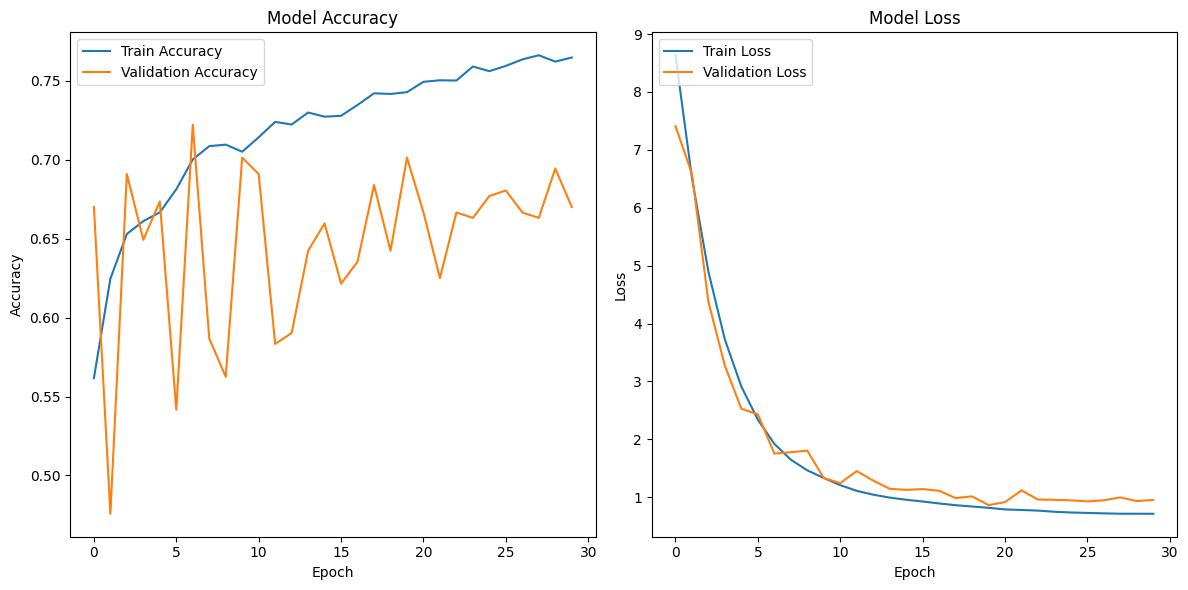

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9008 - loss: 0.3927 - recall_3: 0.8965
Loss on test dataset: 0.6101123690605164
Accuracy on test dataset: 0.8004866242408752
Recall on test dataset: 0.7944039106369019


2024-07-06 11:40:57.107894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step


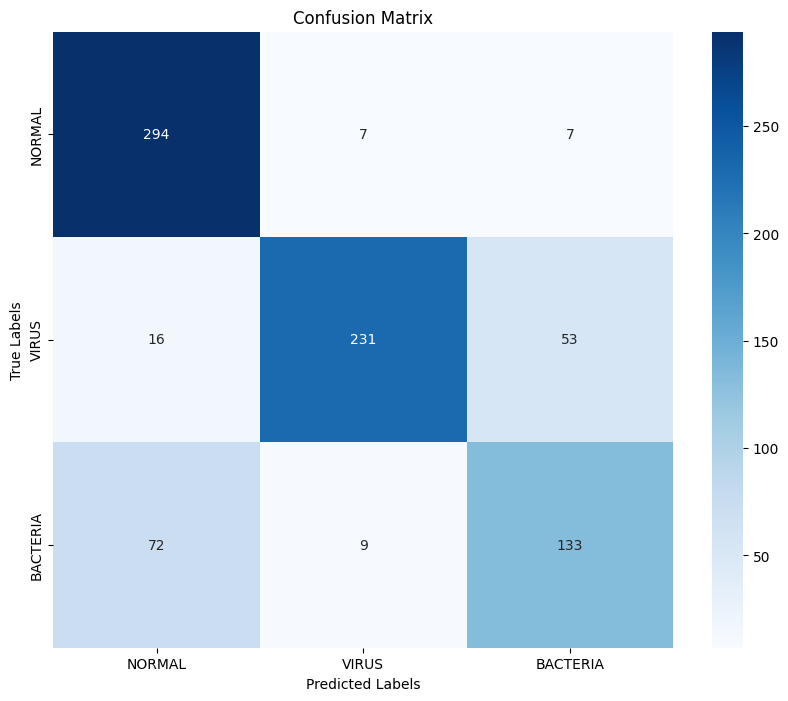

              precision    recall  f1-score   support

      NORMAL       0.77      0.95      0.85       308
       VIRUS       0.94      0.77      0.84       300
    BACTERIA       0.69      0.62      0.65       214

    accuracy                           0.80       822
   macro avg       0.80      0.78      0.78       822
weighted avg       0.81      0.80      0.80       822



In [22]:
def evaluate_model(model, test_dataset):
    test_loss, test_accuracy, test_recall = model.evaluate(test_dataset)
    print(f"Loss on test dataset: {test_loss}")
    print(f"Accuracy on test dataset: {test_accuracy}")
    print(f"Recall on test dataset: {test_recall}")

    test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(true_labels, predicted_labels, target_names=list(class_names.values())))

# Tracer les courbes de précision et de perte
plot_metrics(history)

# Évaluation détaillée sur le jeu de test
evaluate_model(new_model, test_dataset)